In [131]:
import os

import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [132]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

## 下準備

In [133]:
INPUT_DIR = "../input"
OUTPUT_DIR = "../save/base"
SESSION_ID = "session_id"

os.makedirs(OUTPUT_DIR, exist_ok=True)

for p in glob(os.path.join(INPUT_DIR, "*")):
    print(p)

def read_csv(name, **kwrgs):
    path = os.path.join(INPUT_DIR, name + ".csv")
    print(f"Load: {path}")
    return pd.read_csv(path, **kwrgs)

../input/atmaCup13_dataset.zip
../input/atmaCup13_sample_submission.csv
../input/product_master.csv
../input/coupon.csv
../input/test_session.csv
../input/cart_log.csv
../input/session.csv
../input/price.csv
../input/coupon_target_jan.csv


In [134]:
# カートログ
log_df = read_csv("cart_log", parse_dates=["created_at__hour"], dtype={ "JAN": str })

# セッション情報
session_df = read_csv("session", parse_dates=["start_at__date"])
test_session_df = read_csv("test_session")

# クーポン情報
coupon_df = read_csv("coupon")
coupon_target_jan_df = read_csv("coupon_target_jan", dtype={ "JAN": str })

# 商品情報
price_df = read_csv("price", dtype={ "JAN": str })
product_master_df = read_csv("product_master", dtype={ "JAN": str })

Load: ../input/cart_log.csv


/home/yoshikawa/.pyenv/versions/3.8.5/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Load: ../input/session.csv
Load: ../input/test_session.csv
Load: ../input/coupon.csv
Load: ../input/coupon_target_jan.csv
Load: ../input/price.csv
Load: ../input/product_master.csv


In [135]:
def get_target_jan_list():
    """予測対象のカテゴリ(チーズ)のJANコードを取得する"""
    idx = product_master_df["category"] == "チーズ"
    return product_master_df[idx]["JAN"].unique()

# 予測対象の JAN は変わらない (定数) ですので、それがわかるよう CAPITAL で定義します。
TARGET_JANS = get_target_jan_list()

print(f"チーズのJANコード #{len(TARGET_JANS)}")

チーズのJANコード #1696


In [136]:
def calculate_buy_sessions(input_df: pd.DataFrame) -> set:
    """
    180秒後にチーズカテゴリの商品を新規に購入したセッションを取得します.
    
    Args:
        input_df: 
            cart_log.csv のデータ.

    Returns:
        購入があったセッション集合
    """

    idx_after_180 = input_df["duration"] >= 180
    idx_has_cheese = input_df["JAN"].isin(TARGET_JANS)

    # 180秒後かつチーズの商品追加・削除に関係するログにしぼりこんで, 
    _df = input_df[idx_after_180 & idx_has_cheese].reset_index(drop=True)

    # session ごとに JAN (商品) をいくつ買ったかを計算して,
    sum_of_item = _df.groupby(["session_id", "JAN"])["n_items"].sum().reset_index()

    # 新しく購入があった session - JAN の index に絞り
    idx = sum_of_item["n_items"] > 0
    sum_of_item = sum_of_item[idx]

    # session の集合を計算します。これが「チーズを新しく買った」セッションです。
    buy_sessions = sum_of_item["session_id"].unique()
    return set(buy_sessions)

In [137]:
def create_train_test_sessions(session_df: pd.DataFrame, log_df: pd.DataFrame):
    buy_sessions = calculate_buy_sessions(input_df=log_df)
    
    output_df = session_df.copy()
    output_df["target"] = session_df[SESSION_ID].isin(buy_sessions).astype(int)
    
    idx_test = session_df[SESSION_ID].isin(test_session_df[SESSION_ID])
    return output_df[~idx_test].reset_index(drop=True), output_df[idx_test].reset_index(drop=True)

In [138]:
def merge_by_session(left: pd.DataFrame, right: pd.DataFrame, drop_key=True) -> pd.DataFrame:
    out_df = pd.merge(left[SESSION_ID], right, on=SESSION_ID, how="left")
    
    if drop_key:
        out_df = out_df.drop(columns=[SESSION_ID])
    return out_df

In [139]:
def clean_session_df(input_df: pd.DataFrame):
    out_df = input_df.copy()
    out_df["distance_to_the_store"] = input_df["distance_to_the_store"].replace("不明", None).astype(float)
    return out_df

In [140]:
session_df = clean_session_df(session_df)

# #1の講座と違って, 一番最初に train / test のセッションを作っておきます.
train_df, test_df = create_train_test_sessions(session_df=session_df, log_df=log_df)

In [141]:
idx_not_target = ~log_df["JAN"].isin(TARGET_JANS)
idx_train = log_df["session_id"].isin(train_df["session_id"])
use_log_df = log_df[idx_not_target & idx_train].reset_index(drop=True)

In [157]:
def filter_only_train_exclude_target() -> pd.DataFrame:
    # 念の為 target のログデータは消す (何も考えずターゲットの情報を使ってしまうとリークになるため, 安全に行く)
    idx_not_target = ~log_df["JAN"].isin(TARGET_JANS)
    idx_train = log_df["session_id"].isin(train_df["session_id"])
    return log_df[idx_train & idx_not_target].reset_index(drop=True)

def create_user_vector() -> pd.DataFrame:
    """ログデータ由来のユーザの特徴ベクトルを作成する"""
    
    use_log_df = filter_only_train_exclude_target()

    _agg_df = pd.concat([
        # セッション内の行数
        use_log_df.groupby("session_id").size().rename("n_logs"),
        # セッションでの購入した商品数
        use_log_df.groupby("session_id")["n_items"].sum(),
        # セッション中の経過時間の最初と最後
        use_log_df.groupby("session_id")["duration"].agg(["min", "max"]).add_prefix("duration_"),
        # クーポン利用回数
        use_log_df.groupby("session_id")["coupon_is_activated"].sum(),
        # use_log_df.groupby("session_id")["created_at__date"].nunique(),
        
    ], axis=1)
    
    # 完全なログデータがあるのは学習期間のみなので, ユーザの表現ベクトルも学習期間のみを使って作る
    # テスト期間のログは 180秒 しかみれないので、条件が揃わない
    _df = pd.merge(train_df, _agg_df, on=SESSION_ID, how="left")
    out_df = _df.groupby("user_id")[_agg_df.columns].mean().add_prefix("mean_")    
    return out_df

In [158]:
def create_user_vactor_feature_v1(input_df: pd.DataFrame) -> pd.DataFrame:
    """ユーザの特徴ベクトルを紐付ける特徴量"""
    
    # 特徴ベクトルの作成. これをカスタムすると色々作れる!!
    _df = create_user_vector()
    out_df = pd.merge(
        input_df["user_id"], 
        _df, 
        on="user_id", 
        how="left"
    ).drop(columns=["user_id"])
    
    # test にしか現れないユーザはこのままだと Null になるので
    # ユーザベクトルの平均で穴埋めする (ふつーのユーザと思うことにする)
    out_df = out_df.fillna(_df.mean())
    
    return out_df.add_prefix("user_vector__dep=")

In [159]:
create_user_vactor_feature_v1(test_df)

,user_vector__dep=mean_n_logs,user_vector__dep=mean_n_items,user_vector__dep=mean_duration_min,user_vector__dep=mean_duration_max,user_vector__dep=mean_coupon_is_activated
0,29.400000,21.400000,18.200000,1543.400000,0.800000
1,13.625000,8.625000,13.875000,1969.375000,0.187500
2,24.842105,17.789474,11.368421,1797.894737,0.368421
3,15.250000,9.250000,6.750000,594.250000,0.000000
4,22.071429,17.357143,28.000000,1065.857143,0.142857
...,...,...,...,...,...
25818,28.000000,23.111111,7.333333,1075.666667,0.000000
25819,9.785714,8.428571,12.535714,850.964286,0.035714
25820,29.363636,22.181818,8.909091,1736.909091,0.454545
25821,22.302834,16.759948,13.990935,1514.263688,0.206888


In [160]:
def create_distance_to_the_store_feature(input_df: pd.DataFrame) -> pd.DataFrame:
    return merge_by_session(left=input_df, right=session_df[[SESSION_ID, "distance_to_the_store"]])

def create_start_at_date_feature(input_df: pd.DataFrame):
    date_series = session_df["start_at__date"]
    _df = pd.DataFrame({
        SESSION_ID: session_df[SESSION_ID],
        "dayofweek": date_series.dt.dayofweek,
    })
    
    return merge_by_session(input_df, _df)

def create_one_hot_encoding_feature(input_df: pd.DataFrame, target_column: str) -> pd.DataFrame:
    _series = merge_by_session(input_df, session_df)[target_column]
    uniques = session_df[target_column].dropna().unique()

    cat_series = pd.Categorical(_series, categories=uniques)
    out_df = pd.get_dummies(cat_series)
    out_df.columns = out_df.columns.tolist()
    return out_df

def create_session_one_hot_features(input_df: pd.DataFrame) -> pd.DataFrame:
    use_columns = [
        "sex",
        "age"
    ]
    
    out_df = pd.DataFrame()
    
    for c in use_columns:
        _df = create_one_hot_encoding_feature(input_df, target_column=c).add_prefix(f"{c}=")
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

# 何回も使うので, 見えるログを `visible_log_df` として定義しておく
idx_visible = log_df["duration"] < 180
visible_log_df = log_df[idx_visible].reset_index(drop=True)

def create_visible_log_feature(input_df):
    agg_df = pd.concat([
        # セッションごとにイベントが何件あるか
        visible_log_df.groupby("session_id").size().rename("log_size"),

        visible_log_df.groupby("session_id")["n_items"].sum().rename("n_items_sum"),

        visible_log_df.groupby("session_id")["JAN"].nunique().rename("jan_uniques"),
    ], axis=1)

    return merge_by_session(input_df, right=agg_df).add_prefix("visible_log__").fillna(0)

def build_features(input_df):
    feature_functions = [
        create_distance_to_the_store_feature,
        create_start_at_date_feature,
        create_session_one_hot_features,
        create_visible_log_feature,
        # NEW!
        create_user_vactor_feature_v1,
        
        # もっと関数を作ったらここに入れていく!
    ]
    
    print("start build featrures.")
    out_df = pd.DataFrame()

    for func in feature_functions:
        with Timer(prefix=f"\t -run: {func.__name__}..."):
            _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [161]:
train_featuer_df = build_features(train_df)
test_feature_df = build_features(test_df)

start build featrures.
	 -run: create_distance_to_the_store_feature... 0.069[s]
	 -run: create_start_at_date_feature... 0.062[s]
	 -run: create_session_one_hot_features... 0.175[s]
	 -run: create_visible_log_feature... 0.508[s]
	 -run: create_user_vactor_feature_v1... 1.540[s]
start build featrures.
	 -run: create_distance_to_the_store_feature... 0.053[s]
	 -run: create_start_at_date_feature... 0.049[s]
	 -run: create_session_one_hot_features... 0.118[s]
	 -run: create_visible_log_feature... 0.484[s]
	 -run: create_user_vactor_feature_v1... 1.533[s]


In [147]:
# report = sv.compare([train_featuer_df, "train"], [test_feature_df, "test"])
# report.show_html(os.path.join(OUTPUT_DIR, "特徴量__train_vs_test.html"))

In [162]:
X, y = train_featuer_df.values, train_df["target"].values

In [163]:
# 今回は Stratified K Fold を利用
from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=510)
cv = fold.split(X, y)
cv = list(cv) # split の返り値は generator なので list 化して何度も iterate できるようにしておく


from sklearn.metrics import roc_auc_score
import lightgbm as lgbm

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)

        with Timer(prefix="fit fold={} ".format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        # 今回の指標の macro f1 で計算する
        score = roc_auc_score(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = roc_auc_score(y, oof_pred)
    print(f"{score:.4f}")
    return oof_pred, models

In [150]:
goto_params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    "objective": "binary", 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    "learning_rate": .1,

    # L2 Reguralization
    "reg_lambda": .1,
    # こちらは L1 
    "reg_alpha": 0,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    "max_depth": 5, 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    "n_estimators": 10000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    "colsample_bytree": .5, 

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    "min_child_samples": 10,

    # bagging の頻度と割合
    "subsample_freq": 3,
    "subsample": .9,

    # 特徴重要度計算のロジック(後述)
    "importance_type": "gain", 
    "random_state": 71,
}

In [164]:
oof, models = fit_lgbm(X=X, y=y, cv=cv, params=goto_params)

Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.261366
[100]	valid_0's binary_logloss: 0.260106
[150]	valid_0's binary_logloss: 0.259571
[200]	valid_0's binary_logloss: 0.258866
[250]	valid_0's binary_logloss: 0.258678
[300]	valid_0's binary_logloss: 0.258623
[350]	valid_0's binary_logloss: 0.258489
[400]	valid_0's binary_logloss: 0.258629
Early stopping, best iteration is:
[315]	valid_0's binary_logloss: 0.258408
fit fold=0  0.758[s]
 - fold1 - 0.6903
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.263229
[100]	valid_0's binary_logloss: 0.262704
[150]	valid_0's binary_logloss: 0.262254
[200]	valid_0's binary_logloss: 0.262286
[250]	valid_0's binary_logloss: 0.26204
[300]	valid_0's binary_logloss: 0.262473
Early stopping, best iteration is:
[247]	valid_0's binary_logloss: 0.261986
fit fold=1  0.688[s]
 - fold2 - 0.6730
Training until validation scores don't improve for 100 rounds
[50]	valid_0'

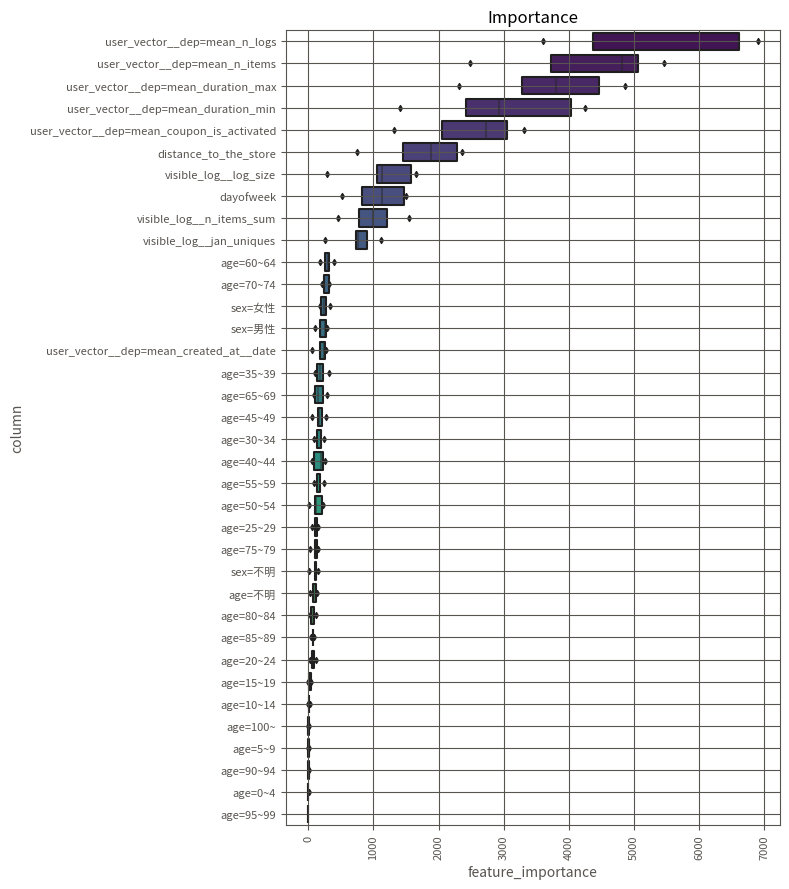

In [152]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_featuer_df)

#### 解釈

* user_vector 系の特徴量が上に来ています。やはりどのユーザの購買なのか、はとても大事なようです。
* 入力されている属性 (sex, age) よりも、購買がどうなっているかから作った特徴量 (user_vector) のほうが大事になっています。
    * 具体的な行動をもとにした情報のほうが有用ということを意味しています。
    * これは年齢や性別は入力されていても、それが正しいとは限らないケースがあることも原因と考えられます (例えば夫のカードを使って買い物している奥さんとか)

In [153]:
def predict(input_df, models):
    # k 個のモデルの予測確率 (predict_proba) を作成. shape = (k, N_test, n_classes).
    pred_prob = np.array([model.predict_proba(input_df.values) for model in models])
    print(f"1. shape: {pred_prob.shape}")

    # k 個のモデルの平均を計算
    pred_prob = np.mean(pred_prob, axis=0) # axis=0 なので shape の `k` が潰れる 
    print(f"2. shape: {pred_prob.shape}")

    # ほしいのは y=1 の確率なので全要素の 1 次元目を取ってくる
    pred_prob = pred_prob[:, 1]
    print(f"3. shape: {pred_prob.shape}")
    return pred_prob

In [154]:
pred_prob = predict(input_df=test_feature_df, models=models)

1. shape: (5, 25823, 2)
2. shape: (25823, 2)
3. shape: (25823,)


/home/yoshikawa/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yoshikawa/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


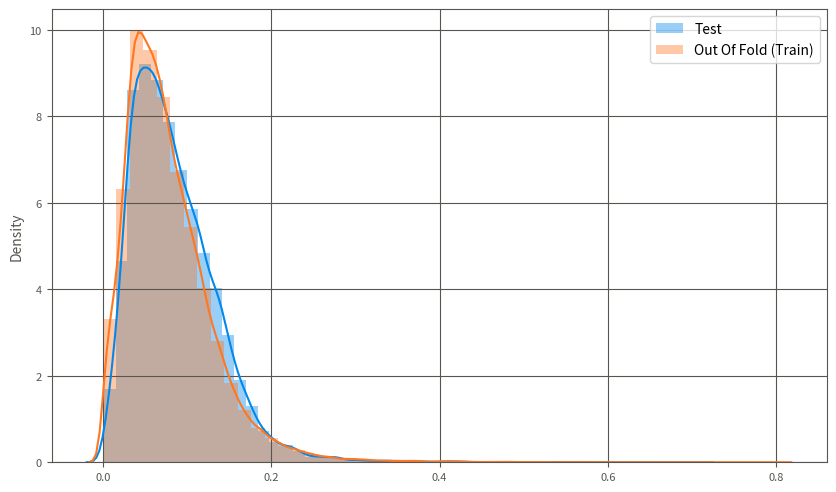

In [155]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.distplot(pred_prob, ax=ax, label="Test")
sns.distplot(oof, ax=ax, label="Out Of Fold (Train)")
ax.legend()
ax.grid()

In [156]:
pd.DataFrame({
    "target": pred_prob
}).to_csv(os.path.join(OUTPUT_DIR, "tutorial_#2_submission.csv"), index=False)